# Вебинар 6. Двухуровневые модели рекомендаций


Код для src, utils, metrics вы можете скачать из [этого](https://github.com/geangohn/recsys-tutorial) github репозитория

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from src.metrics import precision_at_k, recall_at_k, ap_at_k, ndcg_at_k
from src.utils import prefilter_items
from src.recommenders import MainRecommender

In [2]:
data = pd.read_csv('../raw_data/retail_train.csv')
item_features = pd.read_csv('../raw_data/product.csv')
user_features = pd.read_csv('../raw_data/hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)


# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [3]:
n_items_before = data_train_lvl_1['item_id'].nunique()

data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 5001


In [4]:
recommender = MainRecommender(data_train_lvl_1)

/home/user/anaconda3/lib/python3.9/site-packages/implicit/utils.py:33: UserWarning: Intel MKL BLAS detected. Its highly recommend to set the environment variable 'export MKL_NUM_THREADS=1' to disable its internal multithreading
  warnings.warn(


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

In [5]:
recommender.get_als_recommendations(2375, N=5)

[1106523, 845208, 1004906, 1044078, 1133018]

In [6]:
recommender.get_own_recommendations(2375, N=5)

[1106523, 923746, 1133018, 951590, 859075]

In [7]:
recommender.get_similar_items_recommendations(2375, N=5)

[1012307, 1046545, 9527160, 845208, 851287]

In [8]:
recommender.get_similar_users_recommendations(2375, N=5)

[923746, 819765, 1044078, 1038663, 1045586]

### Задание 1

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_lvl_1: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?


In [9]:
# уберём из val_1 id, которых нет в трейне
data_val_lvl_1 = data_val_lvl_1.loc[data_val_lvl_1.user_id.isin(data_train_lvl_1.user_id.unique())]

In [10]:
result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1.columns=['user_id', 'actual']
result_lvl_1.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


##### A) k = 50, разные варианты генерации

In [11]:
k = 50

In [12]:
# топ покупок по датасету для всех
top_recs = recommender.top_purchases.item_id.head(k).to_list()
result_lvl_1['top_purchases'] = result_lvl_1['user_id'].apply(lambda x: top_recs)

In [13]:
result_lvl_1

,user_id,actual,top_purchases
0,1,"[853529, 865456, 867607, 872137, 874905, 87524...","[986912, 951590, 1053690, 1138189, 5569230, 66..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870...","[986912, 951590, 1053690, 1138189, 5569230, 66..."
2,4,"[883932, 970760, 1035676, 1055863, 1097610, 67...","[986912, 951590, 1053690, 1138189, 5569230, 66..."
3,6,"[1024306, 1102949, 6548453, 835394, 940804, 96...","[986912, 951590, 1053690, 1138189, 5569230, 66..."
4,7,"[836281, 843306, 845294, 914190, 920456, 93886...","[986912, 951590, 1053690, 1138189, 5569230, 66..."
...,...,...,...
2133,2496,"[831509, 867188, 1013623, 1048851, 5592734, 16...","[986912, 951590, 1053690, 1138189, 5569230, 66..."
2134,2497,"[820291, 824759, 838797, 859010, 859075, 86077...","[986912, 951590, 1053690, 1138189, 5569230, 66..."
2135,2498,"[865511, 962991, 1076374, 1102358, 5564901, 15...","[986912, 951590, 1053690, 1138189, 5569230, 66..."
2136,2499,"[861282, 921744, 1050968, 13842089, 828837, 86...","[986912, 951590, 1053690, 1138189, 5569230, 66..."


In [14]:
# als
result_lvl_1['als'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_als_recommendations(x, N=k))

In [15]:
# own
result_lvl_1['own'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=k))

In [16]:
# схожие товары
result_lvl_1['similar_items'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_similar_items_recommendations(x, N=k))

In [17]:
# товары схожих пользователей
result_lvl_1['similar_users'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_similar_users_recommendations(x, N=k))

In [18]:
result_lvl_1.head(3)

,user_id,actual,top_purchases,als,own,similar_items,similar_users
0,1,"[853529, 865456, 867607, 872137, 874905, 87524...","[986912, 951590, 1053690, 1138189, 5569230, 66...","[1056509, 9526410, 5569374, 832678, 1082212, 9...","[1106523, 856942, 940947, 9527290, 951590, 107...","[824758, 9526411, 929018, 9297615, 5577022, 11...","[856345, 5568732, 879922, 5569471, 916990, 940..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870...","[986912, 951590, 1053690, 1138189, 5569230, 66...","[1106523, 5569230, 1133018, 951590, 916122, 10...","[1106523, 5569230, 951590, 8090521, 1075368, 1...","[8090509, 5569845, 1106523, 1133018, 844179, 9...","[1082990, 1106523, 859426, 1075368, 8090521, 5..."
2,4,"[883932, 970760, 1035676, 1055863, 1097610, 67...","[986912, 951590, 1053690, 1138189, 5569230, 66...","[951590, 5569230, 1106523, 962229, 965766, 107...","[1106523, 962229, 1075368, 5569230, 951590, 11...","[1040842, 865528, 909915, 1111786, 8069350, 11...","[5569230, 906262, 951590, 1110572, 1033857, 99..."


In [19]:
metrics = pd.DataFrame({'recall@50': []})
for col in result_lvl_1.columns[2:]:
    metrics.loc[col] = result_lvl_1.apply(lambda row: recall_at_k(row[col], row['actual'], k=k), axis=1).mean()

In [20]:
metrics

,recall@50
top_purchases,0.043885
als,0.075172
own,0.071636
similar_items,0.057345
similar_users,0.041529


Наилучший результат - у als, own_recommender ненамного отстаёт. Рекомендация товаров похожих пользователей даёт немного меньшую полноту, чем простая рекомендация товаров из общего топа.

##### B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  

In [21]:
n_candidates = [20, 50, 100, 150, 200, 300, 500, 600]

In [22]:
als_recall = []
result_lvl_1['als_600'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_als_recommendations(x, N=600))
for k in n_candidates:
    recall_k = result_lvl_1.apply(lambda row: recall_at_k(row['als_600'], row['actual'], k=k), axis=1).mean()
    als_recall.append(recall_k)

Text(0.5, 0, 'recall_at_k')

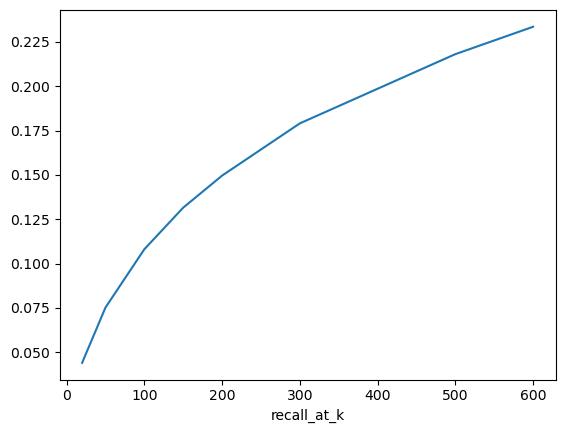

In [23]:
plt.plot(n_candidates, als_recall)
plt.xlabel('k')
plt.xlabel('recall_at_k')

Recall@k растёт при увеличении k: так как метрика максимизирует число правильно рекомендованных, не обращая внимания на ложные срабатывания, то максимальная полнота достижима, если рекомендовать все товары. Но при этом будет минимизироваться точность и увеличиваться затраты на работу алгоритмов. Также увеличение числа кандидатов уменьшит долю реального таргета для второй модели (те для пар user-item усилится дисбаланс классов).

##### C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?

Вероятно, стоит ориентироваться на число покупок пользователей (за период), производительность алгоритмов второго уровня, может быть на общее число уникальных айтемов и пользователей (число пар )- а так же на крутизну графика (такая точка, после которой он растёт медленнее).


In [24]:
# статистика числа покупок за 6 недель
result_lvl_1['actual'].apply(lambda x: len(x)).describe()

count    2138.000000
mean       66.085594
std        58.685592
min         1.000000
25%        20.000000
50%        50.000000
75%        97.000000
max       382.000000
Name: actual, dtype: float64

медиана - 50 покупок, 97 покупок покрывает 75% выборки. И, судя по графику, где-то между 100 и 200 график замедляет рост: т.е. оптимальным для данной выборки кажется k около 100 - 150.

### Задание 2.

Обучите модель 2-ого уровня, при этом:

   - Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар
   - Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_lvl_2
   - Вырос ли precision@5, ap@5, ndcg@5 при использовании двухуровневой модели?

In [25]:
users_lvl_2 = pd.DataFrame(data_train_lvl_2['user_id'].unique(), columns=['user_id'])

train_users = data_train_lvl_1['user_id'].unique()
users_lvl_2 = users_lvl_2[users_lvl_2['user_id'].isin(train_users)]

users_lvl_2['candidates'] = users_lvl_2['user_id'].apply(lambda x: recommender.get_als_recommendations(x, N=150))
users_lvl_2.head(3)

,user_id,candidates
0,2070,"[983584, 9526410, 962229, 893018, 859075, 9237..."
1,2021,"[951590, 1106523, 1044078, 923746, 844179, 845..."
2,1753,"[1106523, 1110572, 1044078, 1096036, 1053690, ..."


In [26]:
s = users_lvl_2.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
s.name = 'item_id'

users_lvl_2 = users_lvl_2.drop('candidates', axis=1).join(s)
users_lvl_2['flag'] = 1

targets_lvl_2 = data_train_lvl_2[['user_id', 'item_id']].copy()
targets_lvl_2['target'] = 1

targets_lvl_2 = users_lvl_2.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')

targets_lvl_2['target'].fillna(0, inplace= True)
targets_lvl_2.drop('flag', axis=1, inplace=True)

targets_lvl_2.head(3)

,user_id,item_id,target
0,2070,983584,0.0
1,2070,9526410,0.0
2,2070,962229,0.0


In [27]:
targets_lvl_2['target'].mean()

0.07553189866853753

In [28]:
# + уже существующие признаки
targets_lvl_2 = targets_lvl_2.merge(item_features, on='item_id', how='left')
targets_lvl_2 = targets_lvl_2.merge(user_features, on='user_id', how='left')

- 3 новых признака для users

Для более чем половины уникальных пользователей из трейна-2 нет данных в user_features

In [29]:
data_train_lvl_2['user_id'].nunique(), user_features['user_id'].nunique()

(2154, 801)

In [30]:
# среднее число покупок в неделю
avg_purchases_per_w = data_train_lvl_2.groupby(['user_id', 'week_no'])['item_id'].agg(n_items='count').reset_index()
avg_purchases_per_w = avg_purchases_per_w.groupby('user_id')['n_items'].mean().reset_index()
avg_purchases_per_w

,user_id,n_items
0,1,22.166667
1,2,25.333333
2,4,8.000000
3,6,17.000000
4,7,22.500000
...,...,...
2149,2496,35.500000
2150,2497,26.666667
2151,2498,11.800000
2152,2499,19.500000


In [31]:
targets_lvl_2 = targets_lvl_2.merge(avg_purchases_per_w, on='user_id', how='left')

In [32]:
# средний чек
avg_check = data_train_lvl_2.groupby(['user_id'])['sales_value'].mean().reset_index().rename(columns={'sales_value': 'avg_ch'})
targets_lvl_2 = targets_lvl_2.merge(avg_check, on='user_id', how='left')

In [33]:
# давность последней транзакции
# но так как размах небольшой (86-91) - можно было бы обойтись и без логарифма
last_tr = data_train_lvl_2.groupby(['user_id'])['week_no'].max().reset_index().rename(columns={'week_no': 'last_tr'})
max_week_no = data_train_lvl_2['week_no'].max()
last_tr['last_tr'] = np.log2(max_week_no + 1 - last_tr['last_tr'])
targets_lvl_2 = targets_lvl_2.merge(last_tr, on='user_id', how='left')

- 2 новых признака для items

In [34]:
# средня цена в категории
# нет Nan, но есть странаяя категория ' ' с нулевой sales_value
# тк для некоторых товаров есть несколько цен - берём все
avg_s_per_departm = data_train_lvl_2[['item_id', 'sales_value']].merge(item_features[['item_id', 'department']], on='item_id', how='left')
avg_s_per_departm = avg_s_per_departm.groupby('department')['sales_value'].mean().reset_index().rename(columns={'sales_value': 'avg_per_departm'})
# словрь для подстановки
avg_s_per_departm = dict(zip(avg_s_per_departm['department'], avg_s_per_departm['avg_per_departm']))

In [35]:
targets_lvl_2['avg_per_departm'] = targets_lvl_2['department'].replace(avg_s_per_departm)

In [36]:
# транзакций в категории за неделю - без учёта quantity
# нормированное на число уникальных товаров в категории
n_items_per_departm = data_train_lvl_2[['item_id', 'week_no']].merge(item_features[['item_id', 'department']], on='item_id', how='left')
n_items_per_departm = n_items_per_departm.groupby(['department', 'week_no'])['item_id'].count().reset_index().rename(columns={'item_id': 'n_items_per_departm'})
n_items_per_departm = n_items_per_departm.groupby(['department'])['n_items_per_departm'].mean().reset_index()

In [37]:
tmp = data_train_lvl_2[['item_id']].merge(item_features[['item_id', 'department']], on='item_id', how='left')
tmp = tmp.groupby(['department'])['item_id'].nunique().reset_index().rename(columns={'item_id': 'nunique_i'})

n_items_per_departm = n_items_per_departm.merge(tmp, on='department', how='left')
n_items_per_departm['n_items_per_departm'] = n_items_per_departm['n_items_per_departm'] / n_items_per_departm['nunique_i']
n_items_per_departm.head(5)

,department,n_items_per_departm,nunique_i
0,,15.750000,8
1,AUTOMOTIVE,1.000000,1
2,CHEF SHOPPE,1.312500,8
3,CNTRL/STORE SUP,1.000000,2
4,COSMETICS,0.204844,406


In [38]:
# + доп. признак nunique_i - число уникальных айтемов в категории
targets_lvl_2 = targets_lvl_2.merge(n_items_per_departm, on='department', how='left')

- 2 новых признака для user-item

In [39]:
# как часто пользователь покупает товары этой категории
# хорошо бы нормировать: число покупок пользователя? число товаров в категории?
freq_purch_per_departm = data_train_lvl_2[['user_id', 'item_id']].merge(item_features[['item_id', 'department']], on='item_id', how='left')
freq_purch_per_departm = freq_purch_per_departm.groupby(['user_id', 'department'])['item_id'].count().reset_index().rename(columns={'item_id': 'freq_purch_per_departm'})
# к числу покупок пользователя
tmp = freq_purch_per_departm.groupby('user_id')['freq_purch_per_departm'].sum().reset_index().rename(columns={'freq_purch_per_departm': 'total_purch'})
freq_purch_per_departm = freq_purch_per_departm.merge(tmp, on='user_id', how='left')
freq_purch_per_departm['freq_purch_per_departm'] = freq_purch_per_departm['freq_purch_per_departm'] / freq_purch_per_departm['total_purch']
# + доп признак - число покупок пользователя
targets_lvl_2 = targets_lvl_2.merge(freq_purch_per_departm, on=['user_id', 'department'], how='left')

In [40]:
# покупал ли пользователь товары данной категории за последнюю неделю
max_week_no = data_train_lvl_2['week_no'].max()
recently_purch = data_train_lvl_2[['user_id', 'item_id', 'week_no']].merge(item_features[['item_id', 'department']], on='item_id', how='left')
recently_purch = recently_purch.loc[recently_purch['week_no'] == max_week_no].groupby(['user_id', 'department'])['item_id'].first().reset_index().rename(columns={'item_id': 'recently_purch'})
recently_purch['recently_purch'] = 1
recently_purch.head(5)

,user_id,department,recently_purch
0,1,DRUG GM,1
1,1,GROCERY,1
2,1,NUTRITION,1
3,1,PRODUCE,1
4,6,DELI,1


In [41]:
targets_lvl_2 = targets_lvl_2.merge(recently_purch, on=['user_id', 'department'], how='left')
targets_lvl_2['recently_purch'] = targets_lvl_2['recently_purch'].fillna(0)

- модель 2 уровня

In [42]:
X_train = targets_lvl_2.drop('target', axis=1)
y_train = targets_lvl_2[['target']]

In [43]:
cat_feats = ['manufacturer', 'department', 'brand', 'commodity_desc', 
             'sub_commodity_desc', 'curr_size_of_product', 'age_desc', 
             'marital_status_code', 'income_desc', 'homeowner_desc', 'hh_comp_desc',
             'household_size_desc', 'kid_category_desc']

In [44]:
X_train[cat_feats] = X_train[cat_feats].astype('category')

In [45]:
lgb = LGBMClassifier(objective='binary', max_depth=7, categorical_column=cat_feats, random_state=42)
lgb.fit(X_train, y_train.values.ravel())

/home/user/anaconda3/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


LGBMClassifier(categorical_column=['manufacturer', 'department', 'brand',
                                   'commodity_desc', 'sub_commodity_desc',
                                   'curr_size_of_product', 'age_desc',
                                   'marital_status_code', 'income_desc',
                                   'homeowner_desc', 'hh_comp_desc',
                                   'household_size_desc', 'kid_category_desc'],
               max_depth=7, objective='binary', random_state=42)

In [46]:
# важность признаков
feats_imp = pd.DataFrame({'feat': lgb.feature_name_,
                          'imortance': lgb.feature_importances_
                         })

feats_imp.sort_values('imortance', ascending=False)

,feat,imortance
6,sub_commodity_desc,597
21,freq_purch_per_departm,420
2,manufacturer,348
22,total_purch,309
7,curr_size_of_product,309
16,avg_ch,200
1,item_id,182
0,user_id,176
15,n_items,136
5,commodity_desc,88


Доля товаров определённой категории в покупках пользователя (freq_purch_per_departm) - на втором месте. Общее число покупок, средний чек и общее число товаров в категории также достаточно значимы.

In [47]:
# вероятность быть таргетом
train_preds_proba = lgb.predict_proba(X_train)[:, 1]
train_preds_proba

array([0.42672384, 0.00635816, 0.35300729, ..., 0.00224191, 0.00358633,
       0.00345739])

In [48]:
# уберём из data.val_2 user_id, которых нет в targets_lvl_2
data_val_lvl_2 = data_val_lvl_2.loc[data_val_lvl_2.user_id.isin(targets_lvl_2.user_id.unique())]

In [49]:
result_lvl_2 = data_val_lvl_2.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_2.columns=['user_id', 'actual']
result_lvl_2.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,6,"[920308, 926804, 946489, 1006718, 1017061, 107..."


In [50]:
res = pd.concat([targets_lvl_2[['user_id', 'item_id', 'target']].reset_index(drop=True), pd.Series(train_preds_proba)], axis=1).rename(columns={0: 'proba'})
res = res.sort_values(['user_id', 'proba'], ascending=False).groupby('user_id')['item_id'].unique().reset_index().rename(columns={'item_id': 'lgb_lvl_2'})
res.head(3)

,user_id,lgb_lvl_2
0,1,"[9655212, 1106523, 10149640, 1133018, 1075074,..."
1,2,"[1106523, 1133018, 916122, 923746, 962568, 914..."
2,4,"[831063, 908531, 923746, 1106523, 1126899, 107..."


In [51]:
# топ 5 
res['lgb_lvl_2'] = res['lgb_lvl_2'].apply(lambda x: x[:5])
res.head(3)

,user_id,lgb_lvl_2
0,1,"[9655212, 1106523, 10149640, 1133018, 1075074]"
1,2,"[1106523, 1133018, 916122, 923746, 962568]"
2,4,"[831063, 908531, 923746, 1106523, 1126899]"


In [52]:
# + рекомендации 2 уровня
result_lvl_2 = result_lvl_2.merge(res, on='user_id', how='left')

In [53]:
# + рекомендации 1 уровня для lvl_2
result_lvl_2['als_5'] = result_lvl_2['user_id'].apply(lambda x: recommender.get_als_recommendations(x, N=5))

In [54]:
result_lvl_2.head(3)

,user_id,actual,lgb_lvl_2,als_5
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[9655212, 1106523, 10149640, 1133018, 1075074]","[1056509, 9526410, 5569374, 832678, 1082212]"
1,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[1015296, 1098844, 903325, 962568, 961554]","[1024306, 878996, 854852, 1026118, 965267]"
2,7,"[840386, 889774, 898068, 909714, 929067, 95347...","[1106523, 1126899, 1070820, 1133018, 923746]","[916122, 1096036, 893018, 866211, 859075]"


- метрики: 

precision@5

In [55]:
lgb_prec5 = result_lvl_2.apply(lambda row: recall_at_k(row['lgb_lvl_2'], row['actual'], k=5), axis=1).mean()
lgb_prec5

0.016125159216284896

In [56]:
als_prec5 = result_lvl_2.apply(lambda row: recall_at_k(row['als_5'], row['actual'], k=5), axis=1).mean()
als_prec5

0.019173874930836277

Модель 1-го уровня показывает лучшую точность.

- ap@5

In [57]:
lgb_ap5 = result_lvl_2.apply(lambda row: ap_at_k(row['lgb_lvl_2'], row['actual'], k=5), axis=1).mean()
lgb_ap5

0.09024846894138205

In [58]:
als_ap5 = result_lvl_2.apply(lambda row: ap_at_k(row['als_5'], row['actual'], k=5), axis=1).mean()
als_ap5

0.09298162729658767

И немного лучше ранжирует по ap@k

- ndcg@5

In [59]:
lgb_ndcg5 = result_lvl_2.apply(lambda row: ndcg_at_k(row['lgb_lvl_2'], row['actual'], k=5), axis=1).mean()
lgb_ndcg5

0.14964494438433057

In [60]:
als_ndcg5 = result_lvl_2.apply(lambda row: ndcg_at_k(row['als_5'], row['actual'], k=5), axis=1).mean()
als_ndcg5

0.1586545245845101

И по ndcg 1 модель ранжирует несколько лучше.

### Финальный проект

Мы уже прошли всю необходимую теорию для финального проекта. Проект осуществляется на данных из вебинара (данные считаны в начале ДЗ).
Рекомендуем вам **начать делать проект сразу после этого домашнего задания**
- Целевая метрика - precision@5. Порог для уcпешной сдачи проекта precision@5 > 25%
- Будет public тестовый датасет, на котором вы сможете измерять метрику
- Также будет private тестовый датасет для измерения финального качества
- НЕ обязательно, но крайне желательно использовать 2-ух уровневые рекоммендательные системы в проекте
- Вы сдаете код проекта в виде github репозитория и csv файл с рекомендациями 